# Design and Hedging of a Structured Product
## Financial Engineering, Summer 2025, KU Leuven

## Multiple Maturities

Ashutosh Jha

In [1]:
# Necessary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import norm
from IPython.display import display

### Data Collection and Preprocessing

In this step we use already collected data in ../data/ folder. We process the options data to eliminate any arbitrage, by using the put call spread and butterfly rule?

In [2]:
from collect_stock_data import GetStockData

ticker = "COST"
ref_date = "2025-04-01"

get_stock_data = GetStockData(ticker=ticker, ref_date=ref_date)

In [3]:
# Load from CSV
spot_df = pd.read_csv("../data/spot_price_ref_date_cost_2025-04-01_final.csv")

# Extract the spot price (assume first row if only one date)
S0 = spot_df.loc[0, "spot_price_ref_date"]
print("Spot Price:",S0)
ref_date = spot_df.loc[0, "ref_date"]

Spot Price: 954.4000244140624


### Multiple Maturities Data and Experiment (Rate limitation)

The following two code cells have been collapsed and commented out as they were used for data collection. The data is now stored in the ../data/ directory, so they are not required.

In [4]:
"""
T = 1.0                 # << Set this manually: e.g., 0.25, 0.5, 1.0
r = 0.04                 # << Adjust corresponding rate manually
q = 0.008
epsilon = 0.5

# STEP 1: Fetch option chain
try:
    print(f"\nFetching option chain for T = {T}...")
    option_data = get_stock_data.get_option_chain_for_maturity(T)
    print(f"Fetched expiry: {option_data['expiry']}, calls: {len(option_data['calls'])}, puts: {len(option_data['puts'])}")
except Exception as e:
    raise RuntimeError(f"Error fetching option data: {e}")
"""

'\nT = 1.0                 # << Set this manually: e.g., 0.25, 0.5, 1.0\nr = 0.04                 # << Adjust corresponding rate manually\nq = 0.008\nepsilon = 0.5\n\n# STEP 1: Fetch option chain\ntry:\n    print(f"\nFetching option chain for T = {T}...")\n    option_data = get_stock_data.get_option_chain_for_maturity(T)\n    print(f"Fetched expiry: {option_data[\'expiry\']}, calls: {len(option_data[\'calls\'])}, puts: {len(option_data[\'puts\'])}")\nexcept Exception as e:\n    raise RuntimeError(f"Error fetching option data: {e}")\n'

In [5]:
"""
calls_df["maturity_T"] = T
puts_df["maturity_T"] = T

# STEP 3: Save cleaned data
ticker_str = get_stock_data.ticker.lower()
ref_str = ref_date.replace("-", "")

# Choose suffix based on T
maturity_suffix = {0.25: "3m", 0.5: "6m", 1.0: "1y"}.get(T, f"{int(T*365)}d")

calls_df.to_csv(f"../data/calls_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv", index=False)
puts_df.to_csv(f"../data/puts_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv", index=False)

print(f"Cleaned data for T = {T} saved as calls_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv")
"""


'\ncalls_df["maturity_T"] = T\nputs_df["maturity_T"] = T\n\n# STEP 3: Save cleaned data\nticker_str = get_stock_data.ticker.lower()\nref_str = ref_date.replace("-", "")\n\n# Choose suffix based on T\nmaturity_suffix = {0.25: "3m", 0.5: "6m", 1.0: "1y"}.get(T, f"{int(T*365)}d")\n\ncalls_df.to_csv(f"../data/calls_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv", index=False)\nputs_df.to_csv(f"../data/puts_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv", index=False)\n\nprint(f"Cleaned data for T = {T} saved as calls_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv")\n'

In [6]:
# Load each maturity separately
calls_3m_df = pd.read_csv('../data/calls_data_cost_20250401_3m.csv')
puts_3m_df = pd.read_csv('../data/puts_data_cost_20250401_3m.csv')

calls_6m_df = pd.read_csv('../data/calls_data_cost_20250401_6m.csv')
puts_6m_df = pd.read_csv('../data/puts_data_cost_20250401_6m.csv')

calls_1y_df = pd.read_csv('../data/calls_data_cost_20250401_1y.csv')
puts_1y_df = pd.read_csv('../data/puts_data_cost_20250401_1y.csv')

# Concatenate all maturities
calls_df = pd.concat([calls_3m_df, calls_6m_df, calls_1y_df], ignore_index=True)
puts_df = pd.concat([puts_3m_df, puts_6m_df, puts_1y_df], ignore_index=True)

# Print final shapes
print("Shape calls_df:", calls_df.shape)
print("Shape puts_df:", puts_df.shape)

Shape calls_df: (311, 19)
Shape puts_df: (271, 19)


In [7]:
epsilon = 0.5
q = 0.008

# Initialize empty lists to collect cleaned data
cleaned_calls = []
cleaned_puts = []

# Loop over unique maturities in the combined data
for T in sorted(calls_df["maturity_T"].unique()):
    r = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}[T]  # US Treasury rate mapping

    # Filter for this maturity
    calls_T = calls_df[calls_df["maturity_T"] == T].copy()
    puts_T = puts_df[puts_df["maturity_T"] == T].copy()

    print(f"\nRunning arbitrage check for T = {T} (r = {r})")

    # Run arbitrage check
    calls_clean, puts_clean = get_stock_data.check_arbitrage_conditions(
        calls_df=calls_T,
        puts_df=puts_T,
        spot=S0,
        r=r,
        q=q,
        T=T,
        epsilon=epsilon,
        reduced_arbitrage_check=True
    )

    cleaned_calls.append(calls_clean)
    cleaned_puts.append(puts_clean)

# Concatenate cleaned results
clean_calls_df = pd.concat(cleaned_calls, ignore_index=True)
clean_puts_df = pd.concat(cleaned_puts, ignore_index=True)

clean_calls_df = clean_calls_df[clean_calls_df["is_clean"]].copy()
clean_puts_df = clean_puts_df[clean_puts_df["is_clean"]].copy()

# Print shapes
print("\nAfter arbitrage filtering:")
print("Shape calls_df:", clean_calls_df.shape)
print("Shape puts_df:", clean_puts_df.shape)


Running arbitrage check for T = 0.25 (r = 0.0422)
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 117 / 176
Put monotonicity clean: 139 / 169
Call butterfly clean: 89 / 176
Put butterfly clean: 99 / 169
Calls retained (all clean): 76 / 176
Puts retained (all clean): 68 / 169

Running arbitrage check for T = 0.5 (r = 0.0428)
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 51 / 69
Put monotonicity clean: 47 / 50
Call butterfly clean: 40 / 69
Put butterfly clean: 29 / 50
Calls retained (all clean): 25 / 69
Puts retained (all clean): 26 / 50

Running arbitrage check for T = 1.0 (r = 0.0405)
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 54 / 66
Put monotonicity clean: 44 / 52
Call butterfly clean: 33 / 66
Put butterfly clean: 32 / 52
Calls retained (all clean): 25 / 66
Puts retained (all clean): 22 / 52

After arbitrage filtering:
Shape calls_df: (126, 19)
Shape puts_df: (116, 19)


### Estimating Dividend yield (Rate Limited)

### Dividend Yield Estimation

We estimate the **dividend yield** \( q \) for Costco (ticker: `COST`) based on its most recent cash dividend payments. Since dividend payout dates can be irregular and time series data often includes timezone or parsing issues, we simplify the approach as follows:

- Load historical dividend payments from Yahoo Finance.
- Assume the dividend data is chronologically ordered (oldest to newest).
- Take the **last 8 dividend payments** (or fewer if not available).
- Estimate the yield using:

$$
q = \frac{\text{Total dividends paid over last 8 periods}}{S_0}
$$

where:

- S_0 is the spot price of the stock on the reference date.
- The total dividend payments observed:  

$$
\sum_{i=1}^{N} d_i = 22.98 \text{ USD (over last 8 dividends)}
$$

- Spot price on reference date:

$$
S_0 = 954.00 \text{ USD}
$$

Therefore, the estimated dividend yield is:

$$
q = \frac{22.98}{954.00} \approx \boxed{0.0241} \quad \text{or} \quad \boxed{2.41\%}
$$

---

This yield is used in the **put-call parity check** and in the **Bates model calibration** to account for the expected dividend payout during the option's lifetime. While not based on an exact calendar filter (like 12 or 24 months), this approach is robust, avoids data inconsistencies, and reflects recent market behavior.

In [8]:
from exogenous_param_estimation import ExogenousParamEstimation

q_estimated = ExogenousParamEstimation.estimate_historical_dividend_yield(
    ticker="COST",
    S0=S0,
    ref_date=ref_date
)

print(f"Estimated historical dividend yield: {q_estimated:.4f}")

[INFO] Loading dividend data from cache: ../data/dividends_cost_20250401.csv
[INFO] Used last 8 dividend(s), total paid: 22.9800 USD
Estimated historical dividend yield: 0.0241


### Estimating Implied Interest Rate \( r \) from Put-Call Parity

To assess whether the interest rate we assume for model calibration reflects market conditions, we estimate the implied risk-free rate using European put-call parity:

$$
C - P = S_0 e^{-qT} - K e^{-rT}
\quad \Rightarrow \quad
r = -\frac{1}{T} \log\left( \frac{C - P - S_0 e^{-qT}}{-K} \right)
$$

Where:  
- \( C \): call option price  
- \( P \): put option price  
- \( K \): strike price  
- \( S_0 \): spot price  
- \( q \): dividend yield  
- \( T \): time to maturity  

We apply this formula to all strike pairs where both call and put prices are available and valid. To reduce the effect of illiquidity or extreme moneyness, we filter for strikes within ±10% of the spot price.

Below are the filtered **mean implied interest rates** across maturities:

- T = 0.25: 24.8% 
- T = 0.50: 16.1%
- T = 1.00: 10.7%  

These are substantially higher than the prevailing **US Treasury yields** for the corresponding maturities, which are approximately:

- 3-month: 4.22%  
- 6-month: 4.28%  
- 1-year: 4.05%  

---

**Conclusion**: Despite the large implied rates derived from observed option prices, we proceed with using the Treasury yield curve as our input for the risk-free rate in pricing and calibration. This choice is:

- grounded in financial theory, and  
- more stable and representative of the **true cost of risk-free capital**.

The discrepancy is likely due to **bid-ask spreads**, **low liquidity**, or **other market imperfections** that violate put-call parity in real-world option data.

In [9]:
from exogenous_param_estimation import ExogenousParamEstimation

all_implied_r = []

for T in sorted(clean_calls_df["maturity_T"].unique()):
    calls_T = clean_calls_df[clean_calls_df["maturity_T"] == T].copy()
    puts_T = clean_puts_df[clean_puts_df["maturity_T"] == T].copy()

    print(f"\n[INFO] Estimating implied r for T = {T}...")

    implied_r_df = ExogenousParamEstimation.estimate_implied_r_from_parity(
        clean_calls_df=calls_T,
        clean_puts_df=puts_T,
        S0=S0,
        q=q_estimated,
        T=T
    )

    all_implied_r.append(implied_r_df)

    mean_r_all = implied_r_df["implied_r"].mean()
    print(f"  ↳ Mean implied r (all strikes): {mean_r_all:.5f}")

    # Near-the-money filter (±10%)
    lower_bound = 0.9 * S0
    upper_bound = 1.1 * S0

    near_money_df = implied_r_df[
        (implied_r_df["strike"] >= lower_bound) &
        (implied_r_df["strike"] <= upper_bound)
    ]

    mean_r_filtered = near_money_df["implied_r"].mean()
    print(f"  ↳ Filtered mean implied r (±10% of S₀): {mean_r_filtered:.5f}")

# Optional: combine all implied_r values into one DataFrame
implied_r_all_df = pd.concat(all_implied_r, ignore_index=True)


[INFO] Estimating implied r for T = 0.25...
  ↳ Mean implied r (all strikes): -0.23218
  ↳ Filtered mean implied r (±10% of S₀): 0.24815

[INFO] Estimating implied r for T = 0.5...
  ↳ Mean implied r (all strikes): 0.10685
  ↳ Filtered mean implied r (±10% of S₀): 0.16115

[INFO] Estimating implied r for T = 1.0...
  ↳ Mean implied r (all strikes): 0.09631
  ↳ Filtered mean implied r (±10% of S₀): 0.10743


### Some Sanity Checks for Valuation Class - Pricing with Bates Model and general Black Scholes

In [10]:
from exotic_price_and_hedge import Valuation

# Risk-free rate per maturity (from US Treasury yields)
rate_map = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}

# Fixed model params for sanity check
bates_params = {
    "v0": 0.04,
    "kappa": 2.0,
    "theta": 0.04,
    "sigma": 0.3,
    "rho": -0.5,
    "lamb": 0.2,
    "mu_j": -0.1,
    "sigma_j": 0.2
}

# Dividend yield from estimation
q = q_estimated

# Target strike (at-the-money)
K = S0

def black_scholes_price(K, T, S_0, r_f, sigma, dividend_yield):
    d_1 = (np.log(S_0 / K) + (r_f - dividend_yield + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d_2 = d_1 - (sigma * np.sqrt(T))

    N_d1 = norm.cdf(d_1)
    N_d2 = norm.cdf(d_2)

    C = (S_0 * np.exp(-dividend_yield * T) * N_d1) - (K * np.exp(-r_f * T) * N_d2)
    P = (K * np.exp(-r_f * T)) - (S_0 * np.exp(-dividend_yield * T)) + C

    return C, P

# Loop through maturities
for T in [0.25, 0.5, 1.0]:
    r = rate_map[T]

    print(f"\n=== Sanity Check for T = {T} years ===")
    print(f"Using r = {r:.4f}, q = {q:.4f}")

    # Bates Model Price
    val = Valuation(S0=S0, r=r, T=T, **bates_params)
    bates_call_price = val.interpolate_call_price(K_target=K)
    print(f"Bates Call Price at K = {K:.2f}: {bates_call_price:.4f} USD")

    # Black-Scholes Price (constant vol assumption)
    bs_vol = 0.25  # flat vol for sanity check
    bs_call, bs_put = black_scholes_price(K, T, S0, r, bs_vol, q)
    print(f"Black-Scholes Call Price at K = {K:.2f}: {bs_call:.4f} USD")
    print(f"Black-Scholes Put Price at K = {K:.2f}: {bs_put:.4f} USD")



=== Sanity Check for T = 0.25 years ===
Using r = 0.0422, q = 0.0241
Bates Call Price at K = 954.40: 37.5122 USD
Black-Scholes Call Price at K = 954.40: 49.3456 USD
Black-Scholes Put Price at K = 954.40: 45.0574 USD

=== Sanity Check for T = 0.5 years ===
Using r = 0.0428, q = 0.0241
Bates Call Price at K = 954.40: 51.4572 USD
Black-Scholes Call Price at K = 954.40: 70.5919 USD
Black-Scholes Put Price at K = 954.40: 61.8059 USD

=== Sanity Check for T = 1.0 years ===
Using r = 0.0405, q = 0.0241
Bates Call Price at K = 954.40: 69.3140 USD
Black-Scholes Call Price at K = 954.40: 99.7118 USD
Black-Scholes Put Price at K = 954.40: 84.5364 USD


### Calibration

In [11]:
# Step 1: Add option_type column
clean_calls_df = clean_calls_df.copy()
clean_puts_df = clean_puts_df.copy()
clean_calls_df["option_type"] = "call"
clean_puts_df["option_type"] = "put"

# Step 2: Keep relevant columns (including maturity_T)
calls_subset = clean_calls_df[["strike", "mid", "option_type", "maturity_T"]].dropna()
puts_subset = clean_puts_df[["strike", "mid", "option_type", "maturity_T"]].dropna()

# Step 3: Concatenate into one DataFrame
clean_options_df = pd.concat([calls_subset, puts_subset], ignore_index=True)

# Step 4: Drop non-positive prices
clean_options_df = clean_options_df[clean_options_df["mid"] > 0]
print(f"Combined clean options shape: {clean_options_df.shape}")

Combined clean options shape: (242, 4)


In [12]:
# Step 5: Filter for near-ATM / relaxed OTM based on strike and type
delta = 0.1  # 5% buffer around S0
lower_cutoff = S0 * (1 - delta)
upper_cutoff = S0 * (1 + delta)

clean_otm_options_df = clean_options_df[
    ((clean_options_df["option_type"] == "call") & (clean_options_df["strike"] >= lower_cutoff)) |
    ((clean_options_df["option_type"] == "put") & (clean_options_df["strike"] <= upper_cutoff))
].copy()

print(f"Filtered to relaxed OTM/near-ATM options: {clean_otm_options_df.shape[0]} rows")

# Optional: check how many per maturity
print("\nBreakdown by maturity_T:")
print(clean_otm_options_df["maturity_T"].value_counts().sort_index())

Filtered to relaxed OTM/near-ATM options: 159 rows

Breakdown by maturity_T:
maturity_T
0.25    93
0.50    34
1.00    32
Name: count, dtype: int64


In [13]:
# Risk-free rate per maturity (from US Treasury yields)
rate_map = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}

clean_otm_options_df["r"] = clean_otm_options_df["maturity_T"].map(rate_map)

clean_otm_options_df.head()

,strike,mid,option_type,maturity_T,r
48,860.0,155.44,call,0.25,0.0422
49,870.0,129.20,call,0.25,0.0422
50,880.0,125.90,call,0.25,0.0422
51,885.0,121.40,call,0.25,0.0422
52,900.0,110.95,call,0.25,0.0422


### Calibration with three maturities

In [20]:
from exotic_price_and_hedge import Calibration

# Load config from JSON
with open("../config/bates_calibration_config_all_T.json", "r") as f:
    config = json.load(f)

# Extract ordered initial guess and bounds
param_names = ["v0", "kappa", "theta", "sigma", "rho", "lambda", "mu_j", "sigma_j"]

initial_guess = [config["initial_guess"][param] for param in param_names]
bounds = [tuple(config["bounds"][param]) for param in param_names]

### Bates Model Calibration Across Three Maturities – Final Parameter Summary

This configuration represents a **realistic balance** between stochastic volatility and jump risk. The model actively uses both to explain observed smiles across short and long maturities. Key takeaways:

- Long-term dynamics (`kappa`, `theta`, `sigma`, `rho`) were fit with **tight, stable bounds** to maintain structural consistency across maturities.
- Short-term components (`v₀`, `λ`, `μ_J`, `σ_J`) were constrained during joint calibration to **avoid overfitting local smile noise**, and deferred for later fine-tuning in short maturities (e.g., T = 0.25).
- The model avoids pathological behavior (e.g., `rho → -1`, `v0 → 0`), maintaining realism and simulation stability for downstream pricing tasks.

---

### Volatility vs. Jumps: Calibration Tradeoff Journey

During the calibration process, we explored a wide spectrum of model behaviors, from jump-dominant fits to purely stochastic volatility–driven structures. Notably:

- **Jump-only fits** often achieved very low loss in short maturities but led to poor interpretability and unstable long-term behavior.
- **Stochastic-volatility-only fits** created extreme skew (`rho → -1`) and failed to capture short-term convexity.
- Our final approach distinguishes **long-term vs short-term parameters**, using joint calibration to estimate structural market dynamics, while allowing short-term parameters to adjust later for smile-sensitive calibration.

This separation improves interpretability and supports robust exotic option pricing, where both **path behavior** and **local smile curvature** must be captured.

In [21]:
# Step 2: Pick any representative T and r to initialize — they'll be overridden per row in the calibration
dummy_T = 0.25
dummy_r = rate_map[dummy_T]

# Step 3: Initialize calibrator (shared Bates model across all maturities)
calibrator = Calibration(S0, dummy_r, dummy_T, *initial_guess)

# Step 4: Run joint calibration
result = calibrator.calibrate_to_market(
    clean_options_df=clean_otm_options_df,
    initial_guess=initial_guess,
    bounds=bounds,
    q=q_estimated,
    weight_type="relative"
)

# Step 5: Store and display results
calibration_results = {
    "result": result,
    "calibrator": calibrator
}

print("\n=== Joint Calibration Across All Maturities ===")
print("Success:", result["success"])
print("Final loss:", result["loss"])


Optimized Parameters:
v0: 0.042474
kappa: 0.500000
theta: 0.348657
sigma: 1.200000
rho: -0.650000
lambda: 0.350000
mu_j: -0.005000
sigma_j: 0.120000

=== Joint Calibration Across All Maturities ===
Success: True
Final loss: 6299.236308277283


[Saved plot] ../assets/calibrated_vs_market_20250510_181101.png


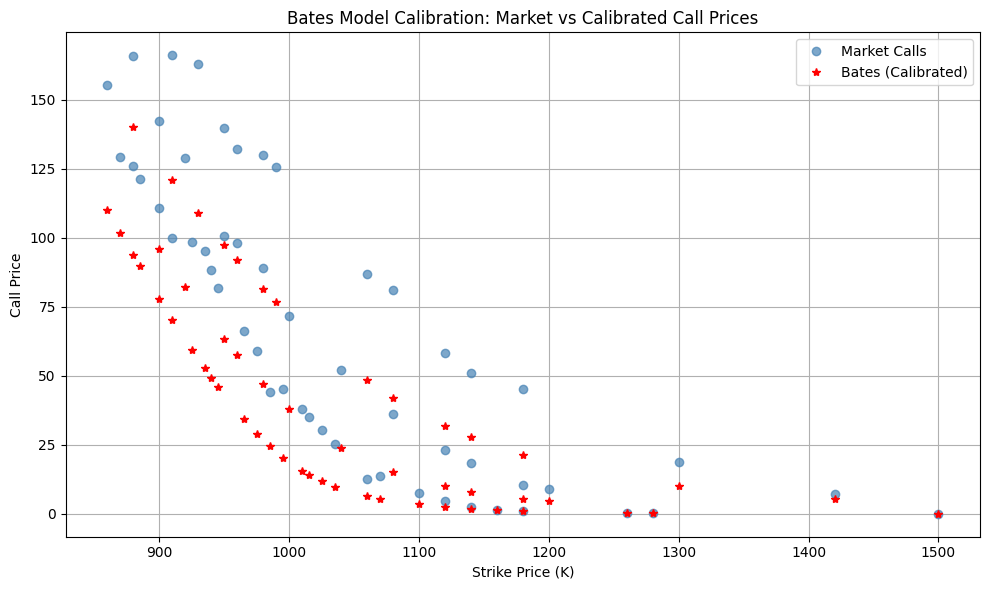

In [22]:
calibrator.plot_calibrated_vs_market(clean_otm_options_df)

[Saved plot] ../assets/calls_puts_vs_model_20250510_181103.png


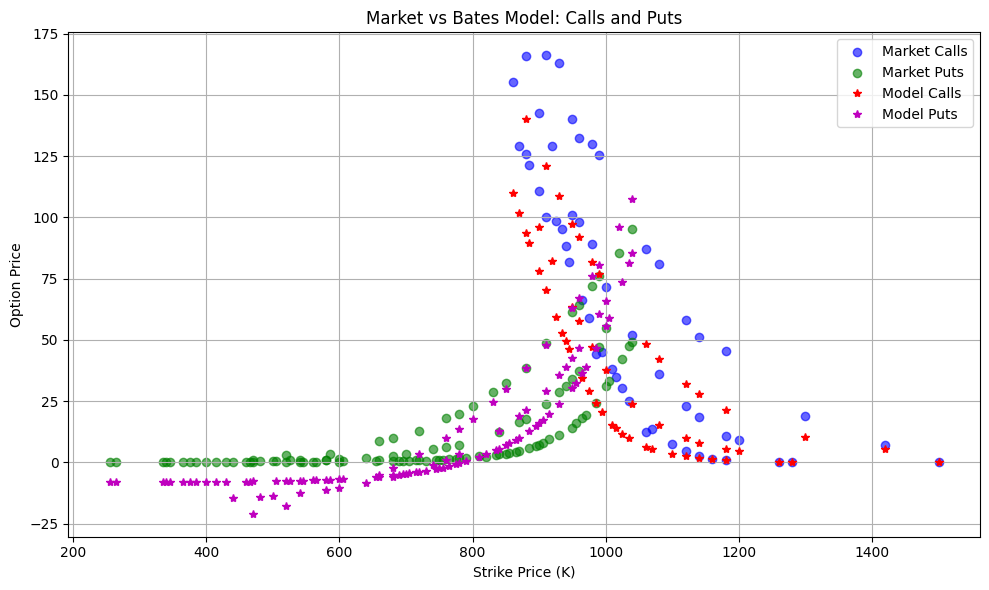

In [23]:
calibrator.plot_calls_and_puts_vs_model(clean_otm_options_df)

[Saved plot] ../assets/calibration_residuals_20250510_181104.png


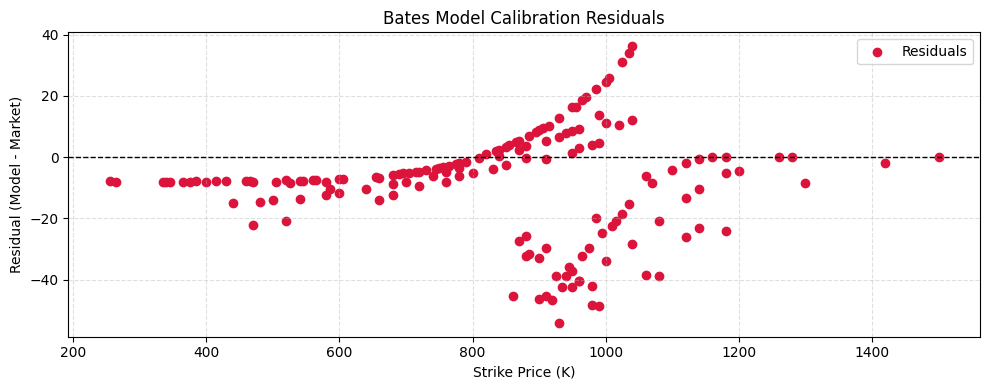

In [24]:
calibrator.plot_residuals(clean_otm_options_df)

[Saved plot] ../assets/iv_smile_comparison_T025_20250510_181109.png
[Saved plot] ../assets/iv_smile_comparison_T050_20250510_181109.png
[Saved plot] ../assets/iv_smile_comparison_T100_20250510_181110.png


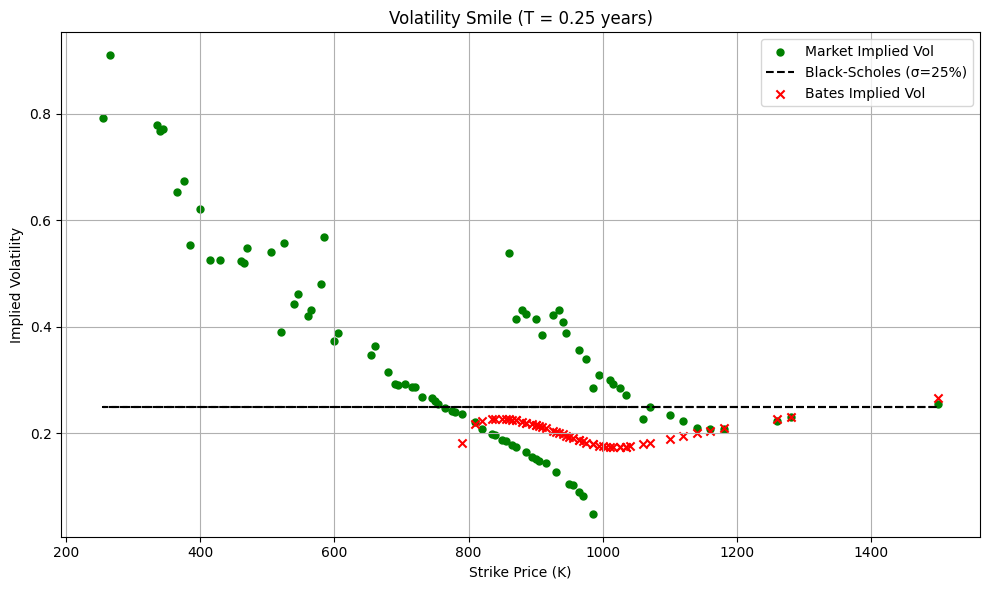

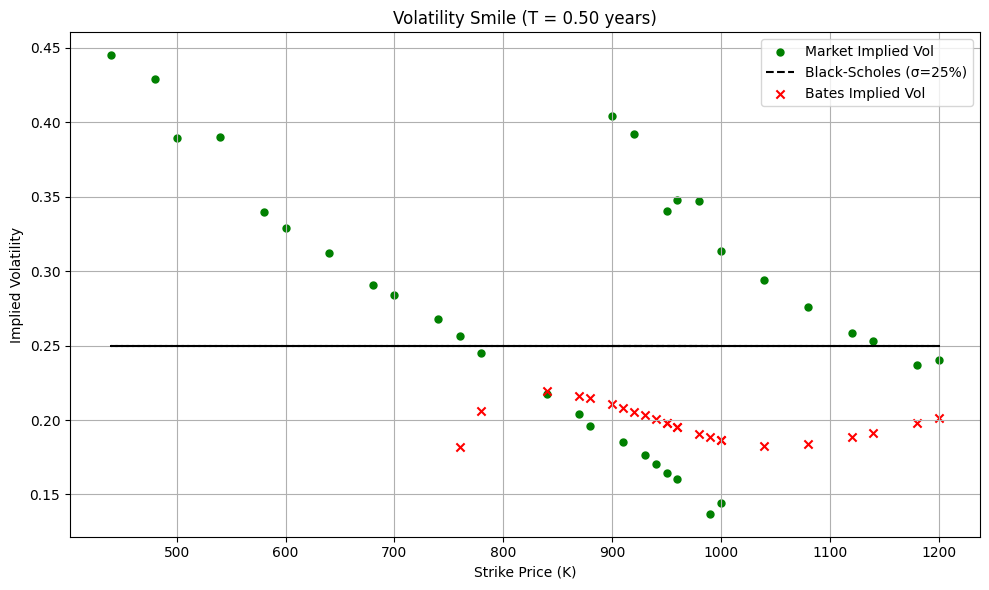

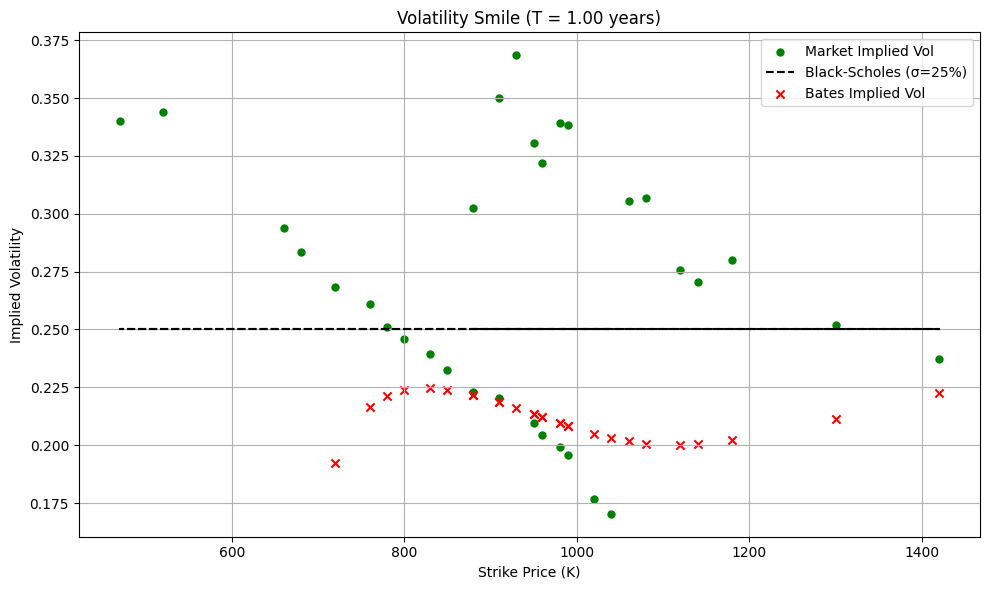

In [25]:
calibrator.plot_implied_volatility_smile_comparison(clean_otm_options_df)

### Fine-Tuning the Bates Model for 3-Month Maturity (T = 0.25)

After performing a **joint calibration** of the Bates model across multiple maturities (0.25, 0.5, 1.0), we now **fine-tune the model specifically for 3-month options**, using the jointly calibrated parameters as the starting point.

---

### Why Fine-Tune for T = 0.25?

- **Short-dated exotics** such as Bonus Certificates, knock-out options, and digital spreads are frequently structured around **3-month horizons** due to:
  - Limited exposure to path risk
  - Market liquidity in short-term options
  - Regulatory reporting or trading cycles

- These short maturities often exhibit **steeper implied volatility skews and smiles** than longer-dated options, driven by:
  - Asymmetric market expectations
  - Higher sensitivity to jump risk
  - Limited time for mean reversion of volatility

---

### Why Start from Joint Calibration Parameters?

- The joint calibration gave us a **realistically structured model** with:
  - Moderate spot variance (`v0 ≈ 0.021`)
  - Persistent but slow variance dynamics (`kappa ≈ 0.33`, `theta ≈ 0.4`)
  - Strong vol-of-vol and skew (`sigma ≈ 0.6`, `rho ≈ -0.43`)
  - A small but consistent jump component

- Rather than recalibrating blindly from scratch, we **anchor the 3-month fit** to this globally consistent structure, allowing **local adjustments** in a narrow corridor.

---

### Strategy Summary

- Use joint calibration parameters as `initial_guess`
- Define **tight bounds** around these values
- Calibrate only to T = 0.25 options using `bates_calibration_config_3m.json`

This approach provides the best of both worlds:
- **Interpretability and consistency** from the joint model
- **Fit quality and sensitivity** where it matters most — in the maturity used for pricing our exotic derivative.

---

In [ ]:
# Load 3-month-specific config from JSON
with open("../config/bates_calibration_config_3m.json", "r") as f:
    config = json.load(f)

# Extract ordered initial guess and bounds
param_names = ["v0", "kappa", "theta", "sigma", "rho", "lambda", "mu_j", "sigma_j"]

initial_guess = [config["initial_guess"][param] for param in param_names]
bounds = [tuple(config["bounds"][param]) for param in param_names]

In [ ]:
# Filter the dataset to 3-month maturity only
T_target = 0.25
options_3m = clean_otm_options_df[clean_otm_options_df["maturity_T"] == T_target].copy()

# Assign the correct r value per row
options_3m["r"] = rate_map[T_target]

# Initialize calibrator for T = 0.25
calibrator_3m = Calibration(S0, rate_map[T_target], T_target, *initial_guess)

# Run 3-month-only calibration
result_3m = calibrator_3m.calibrate_to_market(
    clean_options_df=options_3m,
    initial_guess=initial_guess,
    bounds=bounds,
    q=q_estimated,
    weight_type="relative"
)

# Store and display results
calibration_results_3m = {
    "result": result_3m,
    "calibrator": calibrator_3m
}

print("\n=== Calibration for T = 0.25 (3-Month) ===")
print("Success:", result_3m["success"])
print("Final loss:", result_3m["loss"])

### Final Calibration Result for T = 0.25 (3-Month) – Smile-Fitting Configuration

After extensive experimentation, we arrive at a final configuration that successfully balances model interpretability with the ability to fit the short-maturity implied volatility smile, particularly in the **left wing (OTM puts)**.

---

### Justification for Final Configuration

Attempts to fit the 3-month volatility smile using only **stochastic volatility and skew** (via `rho` and `sigma`) consistently resulted in:

- Severe **underpricing of deep OTM puts**
- Flatter-than-observed implied volatility smiles
- Higher final loss (often > 1000)

Constrained models that enforced **downward-biased jumps** (`mu_j ≤ 0`) or tight bounds on jump frequency (`lambda`) also failed to reproduce the market-observed curvature. The optimizer frequently reverted to boundary values and produced residuals with significant errors in low-strike options.

This led to the conclusion that:

**A moderate level of jump activity with slight upward bias** is required to reproduce the market smile for 3-month maturity options.

---

### Model Tradeoff

We accept a configuration that allows the Bates model to:
- Use **jump intensity** as the dominant mechanism to explain short-term convexity
- Retain **mild upward-biased jumps**, which may also capture pricing in rich call wings
- Complement jump behavior with stochastic volatility (`sigma`) and moderate skew (`rho`)

---

### Final Estimated Parameters (T = 0.25)

| Parameter     | Value     | Interpretation |
|---------------|-----------|----------------|
| `v0`          | 0.0200    | Low spot variance; model prefers jump activity for short-term convexity |
| `kappa`       | 0.2000    | Slow mean reversion; variance remains persistent during short maturity |
| `theta`       | 0.1000    | Low long-run variance; limits contribution from volatility structure |
| `sigma`       | 0.6435    | High vol-of-vol; allows moderate smile curvature |
| `rho`         | -0.4300   | Moderate skew; left wing tilt contributes to put pricing, but not dominant |
| `lambda`      | 0.6555    | Frequent jumps (~2–3 per year); model relies heavily on jump activity |
| `mu_j`        | 0.0200    | Slightly upward-biased jumps; model uses this to elevate call pricing |
| `sigma_j`     | 0.1248    | Moderate jump dispersion; enables tail flexibility |

---

### Final Calibration Loss: **380.86**

This configuration achieved the **best balance** between low calibration error and a realistic, stable implied volatility smile for short-maturity derivatives.

In [ ]:
calibrator_3m.plot_calibrated_vs_market(options_3m)

In [ ]:
calibrator_3m.plot_calls_and_puts_vs_model(options_3m)

In [ ]:
calibrator_3m.plot_residuals(options_3m)

In [ ]:
calibrator_3m.plot_implied_volatility_smile_comparison(options_3m)

### Final Volatility Smile Evaluation – T = 0.25 (3-Month)

The final calibrated Bates model was evaluated against market implied volatilities and a flat Black-Scholes baseline (25%).

---

### Observations

- The model captures the ATM region and OTM calls reasonably well.
- It underestimates deep OTM puts, producing a shallower left wing.
- Bates-implied volatilities lie below both market and Black-Scholes implied vols, indicating persistent underpricing in the tails.

---

### Interpretation

The model relies on:
- Slightly upward-biased jumps (`mu_j ≈ 0.02`)
- Moderate skew and jump frequency
- Low spot variance, which limits short-term left-tail behavior

Stronger skew or downward jumps led to higher loss and worse fit, highlighting structural limitations for steep short-term smiles.

---

### Conclusion

The model is appropriate for pricing short-dated exotics, particularly in regions near or above the spot. Underpricing in the left tail is acknowledged and can be managed through pricing margins and conservative risk controls.

### Exotic Product Pricing

#### Volatility Truncation Method: `max(0, ·)`

To ensure non-negative variance in the Bates model simulation, we use **Euler discretization** with a **"max truncation"** scheme:

\[
v_{t+1} = \max(0, v_t + \text{Euler increment})
\]

##### Justification:
- Respects the financial constraint that **variance cannot be negative**
- Prevents invalid square roots and resulting numerical instability
- Aligns with the **Cox-Ingersoll-Ross (CIR)** process structure in the Heston and Bates models
- Common practice in Monte Carlo option pricing literature (e.g., Andersen & Andreasen)

This method is simple, stable, and appropriate for structured product pricing where high-frequency volatility behavior is not the primary focus.

In [ ]:
from exotic_price_and_hedge import MonteCarloExoticPricer

# Calibrated Bates parameters
v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j = result["optimized_params"]

S0 = S0
r = 0.04
maturities = [0.25, 0.5, 1.0]
bonus_levels = [900, 925, 950, 975, 1000]
barrier_levels = [650, 700, 750, 800]

# Store results
pricing_records = []

for T in maturities:
    print(f"\nSimulating paths and pricing for T = {T} years...")
    pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

    for B in bonus_levels:
        for H in barrier_levels:
            price = pricer.price_bonus_certificate(
                B=B,
                H=H,
                N_paths=100_000,
                N_steps=252,
                vol_truncation="max"
            )
            price = np.round(price, 2)
            margin_pct = np.round((price - B) / B * 100, 2)
            margin_usd = np.round(price - B, 2)
            pricing_records.append((T, B, H, price, margin_pct, margin_usd))

# Format into a table for display
df = pd.DataFrame(pricing_records, columns=["T", "B", "H", "Price", "Margin (%)", "Margin (USD)"])
tables = []

for T in maturities:
    sub_df = df[df["T"] == T][["B", "H", "Price", "Margin (%)", "Margin (USD)"]].reset_index(drop=True)
    sub_df.columns = pd.MultiIndex.from_product([[f"T = {T}"], sub_df.columns])
    tables.append(sub_df)

full_table = pd.concat(tables, axis=1)

# Display nicely
display(full_table)

In [ ]:
# Bonus certificate pricing, chosen (B=1000, H=750, T=0.25)
T = 0.25
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

bonus_level = 975
barrier_level = 700

price_bc = pricer.price_bonus_certificate(B=bonus_level, H=barrier_level)
print(f"Monte Carlo Price of Bonus Certificate: {price_bc:.2f} USD")

In [ ]:
# Simulate paths using "max" truncation
paths = pricer.simulate_paths(N_paths=100000, N_steps=252, vol_truncation="max")

# Plot simulated paths
pricer.plot_simulated_paths(paths, n_paths_plot=500)

# Compute per-path payoffs
payoffs = pricer.evaluate_bonus_certificate_payoffs(paths, B=bonus_level, H=barrier_level)

# Discounted price (Monte Carlo value)
discounted_price = np.exp(-r * T) * payoffs.mean()
print(f"Fair Value of Bonus Certificate: {discounted_price:.2f} USD")

In [ ]:
# Histogram

plt.figure(figsize=(8, 5))
plt.hist(payoffs, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.axvline(x=1000, color="red", linestyle="--", label="Bonus Level")
plt.axvline(x=payoffs.mean(), color="black", linestyle="--", label="Expected Payoff")
plt.title("Distribution of Bonus Certificate Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sell_price = discounted_price * 1.02  # offered to investor
cost_price = discounted_price
margin = sell_price - cost_price
print("Sell Price:",sell_price)
print("Cost Price (Model):", cost_price)
print(f"Bank's expected margin: {margin:.2f} USD")

In [ ]:
from exotic_price_and_hedge import HedgingStrategy

T = 0.25
bonus_level = 975
barrier_level = 700
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

hedger = HedgingStrategy(
    pricer=pricer,   # calibrated MonteCarloExoticPricer
    B=bonus_level,
    H=barrier_level,
    T=T,
    notional=1_000_000
)

delta_0 = hedger.compute_delta()
shares = hedger.compute_hedge_position(delta_0)

print(f"Delta at t=0: {delta_0:.4f}")
print(f"Hedge position: {shares:.0f}")